# Building and Testing Corrective RAG

[Corrective-RAG (CRAG)](https://arxiv.org/abs/2401.15884) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents.

Here's we're going to show two different way to implement Corrective-RAG:

1. We will implement this as a [ReAct agent](https://react-lm.github.io/).

2. We will implement this agent as a custom / user-defined control flow in LangGraph.

3. Then, we will show how to test these agents.

4. We'll build an [evaluation set of question-answer pairs for RAG in LangSmith](https://docs.smith.langchain.com/tutorials/Developers/agents#eval).

5. We'll evaluate end-to-end performance of our agents along with the specific reasoning trace of each one.

In [27]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "corrective-rag-agent-testing"

### ⚙️  |  Settings

In [28]:
LLM_MODEL_OPENAI = "gpt-4o"
LLM_MODEL_FIREWORKS = "firefunction-v2"

METADATA = "CRAG, gpt-4o"
TEMPERATURE = 0.0

OLLAMA_NOMIC_EMBEDDING = "nomic-embed-text"
OLLAMA_EMBEDDING_SHOW_PROGRESS = False
K_NEAREST_NEIGHBORS = 4

INGEST_KNOWLEDGE = False

### 🧠  |  LLM

Select the LLM to use for both of our agents.

This can be easily swapped with [other models that support tool use](https://python.langchain.com/v0.2/docs/integrations/chat/)!

In [29]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name=LLM_MODEL_OPENAI, temperature=TEMPERATURE)

For example, we can also test [Firefunction-v2](https://fireworks.ai/blog/firefunction-v2-launch-post), a Llama 3-70b fine-tuned for tool calling.

In [30]:
# from langchain_fireworks import ChatFireworks

# llm = ChatFireworks(
#     model=f"accounts/fireworks/models/{LLM_MODEL_FIREWORKS}", temperature=TEMPERATURE
# )

### 🕵🏻  |  ReAct Agent

First, we'll define our [ReAct agent](https://python.langchain.com/v0.2/docs/tutorials/agents/) for corrective RAG!

LLM powered autonomous agents [use three things to accomplish tasks](https://lilianweng.github.io/posts/2023-06-23-agent/):

- `Tools`: Actions to gather external information that is missing from the model weights
- `Planning`: Often this is self-criticism and self-reflection over past actions
- `Memory`: Ability to recall information (e.g., from the user or from past actions)

[ReAct](https://arxiv.org/abs/2210.03629) is a popular that incorporates explicit steps for LLM to:

- `Action`: Choose an action (e.g., often a tool)
- `Observation`: Observe the outputs of the action
- `Think`: Reason about the next step

These steps follow a loop until the agent stops calling tools and decides to return a final answer.

Let's set up our ReAct agent by first defining a few tools.

### 🔧 | Embeddings (Do not show progress)

In [31]:
from langchain_community.embeddings import OllamaEmbeddings

embeddings = OllamaEmbeddings(
    model=OLLAMA_NOMIC_EMBEDDING, show_progress=OLLAMA_EMBEDDING_SHOW_PROGRESS
)

### 🛠️ | Vector Store 

In [32]:
from langchain_community.vectorstores import Chroma

CHROMA_COLLECTION_NAME = "blogposts"
CHROMA_PERSIST_DIRECTORY = "./db-chromadb"

db = Chroma(
    persist_directory=CHROMA_PERSIST_DIRECTORY,
    embedding_function=embeddings,
    collection_name=CHROMA_COLLECTION_NAME,
)

print(f"There are {db._collection.count()} in the <{db._collection.name}> collection.")

There are 182 in the <blogposts> collection.


### 📥 | Ingest

In [33]:
if INGEST_KNOWLEDGE:
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    from langchain_community.document_loaders import WebBaseLoader

    urls = [
        "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
        "https://lilianweng.github.io/posts/2024-02-05-human-data-quality/",
        "https://lilianweng.github.io/posts/2023-06-23-agent/",
        "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
        "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
    ]

    docs = [WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]

    # Initialize a text splitter with specified chunk size and overlap
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1500, chunk_overlap=300, add_start_index=True
    )

    # Split the documents into chunks
    doc_splits = text_splitter.split_documents(docs_list)

    vectorstore = db.from_documents(
        documents=doc_splits,
        embedding=embeddings,
        persist_directory=CHROMA_PERSIST_DIRECTORY,
        collection_name=CHROMA_COLLECTION_NAME,
    )

In [34]:
retriever = db.as_retriever(
    search_type="similarity", search_kwargs={"k": K_NEAREST_NEIGHBORS}
)

print(
    f"There are {db._collection.count()} vectors in the <{db._collection.name}> collection."
)

There are 182 vectors in the <blogposts> collection.


### 🧰  |  Tools

When we define this as a tool and bind it too the LLM, then the LLM can:
- Choose to call this tool
- Formulate the payload needed to run the tool

In [35]:
from langchain_core.tools import tool


# Define a tool, which we will connect to our agent
@tool
def retrieve_documents(query: str) -> list:
    """Retrieve documents from the vector store based on the query."""
    return retriever.invoke(query)

We'll create a tool that instructs our agent to reflect on the retrieved documents.

In [36]:
@tool
def grade_document_retrieval(step_by_step_reasoning: str, score: int) -> str:
    """You are a teacher grading a quiz. You will be given:
    1/ a QUESTION
    2/ a set of comma separated FACTS provided by the student

    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the FACTS are relevant to the QUESTION.
    A score of 0 means that NONE of the FACTS are relevant to the QUESTION.

    If your score is 1: then call a tool to generate the answer, generate_answer
    If your score is 0: then call a tool to perform web search, web_search."""
    if score == 1:
        return "Docs are relevant. Generate the answer to the question."
    return "Docs are not relevant. Use web search to find more documents."

We'll create a tool for web search using Tavily.

In [37]:
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()


@tool
def web_search(query: str) -> str:
    """Run web search on the question."""
    web_results = web_search_tool.invoke({"query": query})
    return [
        Document(page_content=d["content"], metadata={"url": d["url"]})
        for d in web_results
    ]

Finally, we'll create a tool that instructs our agent to produce the final distillated answer.

In [38]:
@tool
def generate_answer(answer: str) -> str:
    """You are an assistant for question-answering tasks.
    Use the retrieved documents to answer the user question.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise"""
    return f"Here is the answer to the user question: {answer}"

Now, we store these in a tools list, which we will bind to our LLM.

In [39]:
tools = [retrieve_documents, grade_document_retrieval, web_search, generate_answer]

### 🚀 | Prompt Templates 

In [40]:
from jinja2 import Environment, FileSystemLoader
from langchain_core.prompts import ChatPromptTemplate

PROMPTS_PATH = "prompts"
RAG_REACT_FILENAME = "rag-react.jinja"

env = Environment(loader=FileSystemLoader(PROMPTS_PATH))
template = env.get_template(RAG_REACT_FILENAME)

### 🗺️  |  Planning

Now, we'll define an LLM assistant for our agent, which can use the tools we defined above.

In [41]:
from typing import Annotated, List

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.

        Args:
            runnable (Runnable): The runnable instance to invoke.
        """
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        """
        Call method to invoke the LLM and handle its responses.
        Re-prompt the assistant if the response is not a tool call or meaningful text.

        Args:
            state (State): The current state containing messages.
            config (RunnableConfig): The configuration for the runnable.

        Returns:
            dict: The final state containing the updated messages.
        """
        while True:
            result = self.runnable.invoke(state)  # Invoke the LLM
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Create the primary assistant prompt template
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            " You are a helpful assistant tasked with answering user questions using the provided vector store. "
            " Use the provided vector store to retrieve documents. Then grade them to ensure they are relevant before answering the question. ",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt our LLM and bind tools
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

### Memory

Finally, we'll using [LangGraph](https://langchain-ai.github.io/langgraph/) to orchestrate our agent.

LangGraph is a library for building agents, which allows us to define 2 nodes:

- `Assistant`, which will contain the `assistant_runnable` defined above
- `Tool`, which will call the tool when the assistant instructs and return the tool outputs to our assistant

LangGraph allows us to define state, which will serve as short-term memory over the lifetime of our agent.

First, there are some utilities that we'll use to help define the graph.

In [42]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state: State) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

Now, we'll define our graph.

We'll simply cycle between 2 nodes:

* Our `assistant` node reasons and plans which tool to use
* Our `tool` node that executes the tool

It will continue as long as our `assistant` is making a tool call.

This shows the general flow:


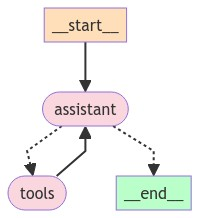

In [43]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Finally, we can our agent!

In [44]:
import uuid


def predict_react_agent_answer(example: dict):
    """Use this for answer evaluation"""

    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    messages = react_graph.invoke({"messages": ("user", example["input"])}, config)
    return {"response": messages["messages"][-1].content, "messages": messages}


example = {"input": "What are the types of agent memory?"}
response = predict_react_agent_answer(example)

In [45]:
def find_tool_calls_react(messages):
    """
    Find all tool calls in the messages returned from the ReAct agent
    """
    tool_calls = [
        tc["name"] for m in messages["messages"] for tc in getattr(m, "tool_calls", [])
    ]
    return tool_calls

find_tool_calls_react(response['messages'])

['retrieve_documents', 'grade_document_retrieval', 'generate_answer']

Follow the trace at https://smith.langchain.com/

We see follow the tool calls to clearly see the reasoning trace:

* Our agent first calls `retrieve_documents` tool to get documents.

* Then, it calls `grade_document_retrieval` tool and deems the documents to be relevant.

## Custom LangGraph Agent

Now, we'll do the same as shown above. But rather that following the ReAct agent control flow, we'll use a custom control flow.

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

First, we'll define a RAG chain to produce our final answer.

In [48]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template=template.render(), input_variables=["question", "documents"]
)

rag_chain = prompt | llm | StrOutputParser()

Now, we'll define a document grader to review our documents.

In [49]:
from langchain_core.pydantic_v1 import BaseModel, Field


# Data model for the output
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with tool call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a teacher grading a quiz. You will be given:
1/ a QUESTION
2/ a set of comma separated FACTS provided by the student

You are grading RELEVANCE RECALL:
A score of 1 means that ANY of the FACTS are relevant to the QUESTION.
A score of 0 means that NONE of the FACTS are relevant to the QUESTION.
1 is the highest (best) score. 0 is the lowest score you can give.

Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct.

Avoid simply stating the correct answer at the outset."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "FACTS: \n\n {documents} \n\n QUESTION: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

Finally, we'll define our graph.

Before, our state was a set of messages.

Here, our state is a dict of specific entities that we want to persist.

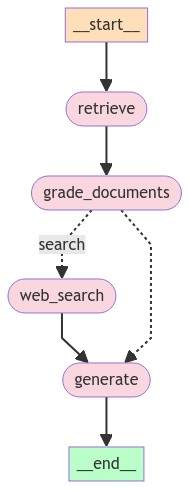

In [50]:
from IPython.display import Image, display


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [51]:
def predict_custom_agent_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "What are the types of agent memory?"}
response = predict_custom_agent_answer(example)
response

{'response': 'The types of agent memory are sensory memory, short-term memory (or working memory), and long-term memory.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}